In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip install deap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 3.9 MB/s eta 0:00:00


In [ ]:
!pip install bitstring

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.3 MB/s eta 0:00:00


In [ ]:
# setting seed for model reproducibility
seed_value = 42
import os
os.environ['PYTHONHASHSEED'] = str(seed_value)
import random
random.seed(seed_value)
import numpy as np
np.random.seed(seed_value)
import tensorflow as tf
tf.random.set_seed(seed_value)
import pandas as pd
from    missingno import matrix
import scipy.stats as stats
from pathlib import Path
import fnmatch
from collections import defaultdict

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler 
from imblearn.over_sampling import SMOTE
from sklearn.metrics import f1_score
import datetime
import math
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=DeprecationWarning)

from tensorflow import keras
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM, GRU, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint
from keras.regularizers import l2
from keras import optimizers
from keras.optimizers import Adam
from time import time
from deap import base, creator, tools, algorithms
from scipy.stats import bernoulli
from bitstring import BitArray

In [ ]:
df = pd.read_csv('/content/gdrive/My Drive/Thesis/Final_Real.csv', index_col=0)

In [ ]:
# Splitting the dataset
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=seed_value)

In [ ]:
# Rescale the features

scaler = StandardScaler() 
train_scaled = pd.DataFrame(scaler.fit_transform(X_train.values),
                                     index=X_train.index,
                                     columns=X_train.columns)
# The Scaler is fit on the training set and then applied to the test set
test_scaled = pd.DataFrame(scaler.transform(X_test.values),
                                    index=X_test.index,
                                    columns=X_test.columns)

train_scaled.shape, test_scaled.shape

((164563, 6), (70527, 6))

With the Genetic Algorithms I want to optimise timesteps size T, number of 
hidden units NUM_HIDDEN, batch size BATCH and number of epochs EPOCH.

In [ ]:
def train_evaluate(individual):
     
    # Decode GA solution to integer for timesteps, num_units, epochs, batch_size and learning rate
    timesteps_bits = BitArray(individual[0:8])
    num_units_bits = BitArray(individual[8:14])
    epoch_bits = BitArray(individual[14:19]) 
    batch_size_bits = BitArray(individual[19:26])    
        
    timesteps = timesteps_bits.uint
    num_units = num_units_bits.uint
    epoch = epoch_bits.uint
    batch_size = batch_size_bits.uint
   
         
    print('\nWindow size: ', timesteps, '\nNum of units: ', num_units, '\nEpoch:', epoch,'\nBatch size:',batch_size)

    # Return fitness score of 100 if window_size, num_unit, epochs or batch size is zero
    if timesteps == 0 or num_units == 0 or epoch == 0 or batch_size == 0:
      return 100,
              
    X_train_1, y_train_1 = [], []
    for i in range(y_train.shape[0] - (timesteps-1)):
      X_train_1.append(train_scaled.iloc[i:i+timesteps].values)
      y_train_1.append(y_train.iloc[i + (timesteps-1)])
    X_train_1, y_train_1 = np.array(X_train_1), np.array(y_train_1).reshape(-1,1)
    print(f'Train data dimensions: {X_train_1.shape}, {y_train_1.shape}')

    X_test_1, y_test_1 = [], []
    for i in range(y_test.shape[0] - (timesteps-1)):
      X_test_1.append(test_scaled.iloc[i:i+timesteps].values)
      y_test_1.append(y_test.iloc[i + (timesteps-1)])
    X_test_1, y_test_1 = np.array(X_test_1), np.array(y_test_1).reshape(-1,1)  
    print(f'Test data dimensions: {X_test_1.shape}, {y_test_1.shape}')

    # LSTM model with 2 stucked GRU layers with activation function relu

    model = Sequential()
    model.add(GRU(num_units, kernel_initializer=keras.initializers.glorot_uniform(seed=seed_value), activation="relu", return_sequences=True, input_shape=(X_train_1.shape[1],  X_train_1.shape[2])))
    model.add(GRU(num_units, kernel_initializer=keras.initializers.glorot_uniform(seed=seed_value), activation='relu'))
    model.add(Dense(9, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
    print(model.summary())


    # Define a learning rate decay method:
    lr_decay = ReduceLROnPlateau(monitor='loss', 
                                patience=1, verbose=1, 
                                factor=0.5, min_lr=1e-8)
    # Define Early Stopping:
    early_stop = EarlyStopping(monitor='val_accuracy', min_delta=0, 
                              patience=30, verbose=1, mode='auto',
                              baseline=0, restore_best_weights=True)

    # Train the model. 
    start = time()
    History = model.fit(X_train_1, y_train_1,
                        epochs=epoch,
                        batch_size=batch_size,
                        validation_data=(X_test_1, y_test_1),
                        shuffle=True,verbose=1,
                        callbacks=[lr_decay, early_stop])
    print('-'*65)
    print(f'Training was completed in {time() - start:.2f} secs')
    print('-'*65)
    
    # get the lowest validation loss of the training epochs
    validation_loss = np.nanmin(History.history['val_loss']) 
    print('Best validation loss of epoch:', validation_loss)
    
    return (validation_loss),

In [ ]:
population_size = 5 
num_generations = 5
gene_length = 26

hof   = tools.ParetoFront()

stats = tools.Statistics(key=lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

In [ ]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()

# Attribute generator
toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register('individual', tools.initRepeat, creator.Individual, toolbox.attr_bool, n = gene_length)
toolbox.register('population', tools.initRepeat, list , toolbox.individual)

toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", train_evaluate)

population = toolbox.population(n = population_size)

# Evolution
pop, logbook = algorithms.eaSimple(population, toolbox, cxpb = 0.4, mutpb = 0.1, ngen = num_generations, halloffame=hof, stats=stats, verbose = True)

/usr/local/lib/python3.10/dist-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "



Window size:  34 
Num of units:  51 
Epoch: 28 
Batch size: 16
Train data dimensions: (164530, 34, 6), (164530, 1)
Test data dimensions: (70494, 34, 6), (70494, 1)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_2 (GRU)                 (None, 34, 51)            9027      
                                                                 
 gru_3 (GRU)                 (None, 51)                15912     
                                                                 
 dense_1 (Dense)             (None, 9)                 468       
                                                                 
Total params: 25,407
Trainable params: 25,407
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/28
10284/10284 [==============================] - 288s 28ms/step - loss: 0.1803 - accuracy: 0.9411 - val_loss: 0.1204 - val_accuracy: 0.

<ipython-input-30-5d1a29b0b072>:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(front[:,0][1:], front[:,1][1:], "-bo", c="b")


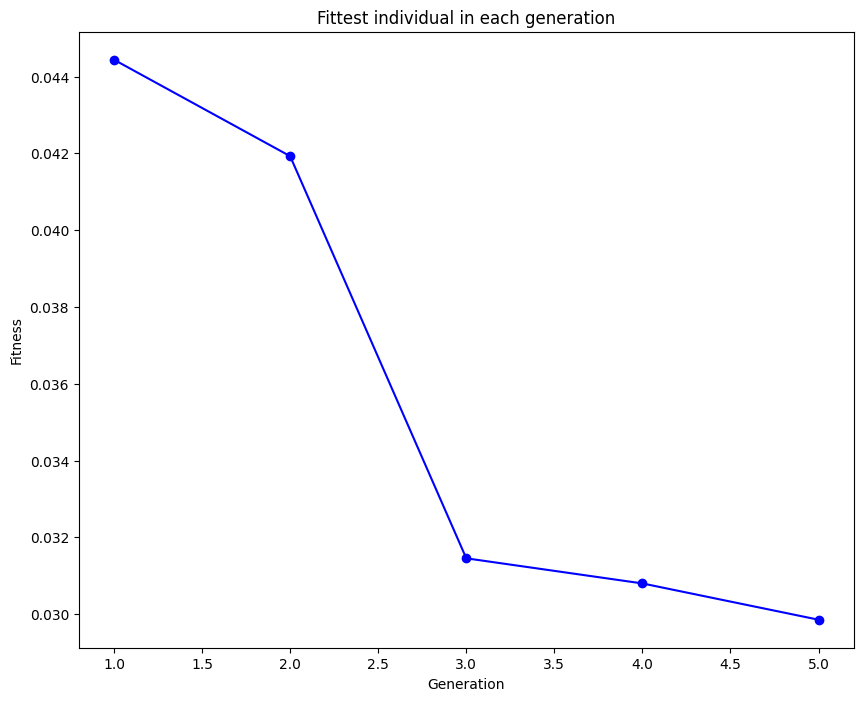

In [ ]:
# History AVG
plt.figure(figsize=(10,8))
front = np.array([(c['gen'], c['avg']) for c in logbook])
plt.plot(front[:,0][1:], front[:,1][1:], "-bo", c="b")
plt.title('Fittest individual in each generation')
plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.show()

In [ ]:
best_individuals = tools.selBest(population,k = 1)
best_timesteps = None
best_num_units = None
best_epoch = None
best_batch_size = None

for bi in best_individuals:
    timesteps_bits = BitArray(bi[0:8])
    num_units_bits = BitArray(bi[8:14])
    epoch_bits = BitArray(bi[14:19]) 
    batch_size_bits = BitArray(bi[19:26])

    best_timesteps = timesteps_bits.uint
    best_num_units = num_units_bits.uint
    best_epoch = epoch_bits.uint
    best_batch_size = batch_size_bits.uint
    print('\nWindow Size: ', best_timesteps, ', Num of Units: ', best_num_units, '\nEpochs: ', best_epoch, '\nBatch Size: ', best_batch_size)


Window Size:  1 , Num of Units:  53 
Epochs:  29 
Batch Size:  25


In [ ]:
# Train the model using best configuration on complete training set 
#and make predictions on the test set

T = best_timesteps
X_train_1, y_train_1 = [], []
for i in range(y_train.shape[0] - (T-1)):
  X_train_1.append(train_scaled.iloc[i:i+T].values)
  y_train_1.append(y_train.iloc[i + (T-1)])
X_train_1, y_train_1 = np.array(X_train_1), np.array(y_train_1).reshape(-1,1)
print(f'Train data dimensions: {X_train_1.shape}, {y_train_1.shape}')

X_test_1, y_test_1 = [], []
for i in range(y_test.shape[0] - (T-1)):
  X_test_1.append(test_scaled.iloc[i:i+T].values)
  y_test_1.append(y_test.iloc[i + (T-1)])
X_test_1, y_test_1 = np.array(X_test_1), np.array(y_test_1).reshape(-1,1)  
print(f'Test data dimensions: {X_test_1.shape}, {y_test_1.shape}')

# GRU model with 2 stucked GRU layers with activation function relu

model = Sequential()
model.add(GRU(best_num_units, activation="relu", return_sequences=True, input_shape=(X_train_1.shape[1],  X_train_1.shape[2])))
model.add(GRU(best_num_units, activation='relu'))
model.add(Dense(9, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
print(model.summary())


# Define a learning rate decay method:
lr_decay = ReduceLROnPlateau(monitor='loss', 
                                patience=1, verbose=1, 
                                factor=0.5, min_lr=1e-8)
# Define Early Stopping:
early_stop = EarlyStopping(monitor='val_accuracy', min_delta=0, 
                              patience=30, verbose=1, mode='auto',
                              baseline=0, restore_best_weights=True)

# Train the model. 
start = time()
History = model.fit(X_train_1, y_train_1,
                        epochs=best_epoch,
                        batch_size=best_batch_size,
                        validation_data=(X_test_1, y_test_1),
                        shuffle=True,verbose=1,
                        callbacks=[lr_decay, early_stop])
print('-'*65)
print(f'Training was completed in {time() - start:.2f} secs')
print('-'*65)

y_pred = np.argmax(model.predict(X_test_1), axis=-1)


Train data dimensions: (164563, 1, 6), (164563, 1)
Test data dimensions: (70527, 1, 6), (70527, 1)
Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_35 (GRU)                (None, 1, 53)             9699      
                                                                 
 gru_36 (GRU)                (None, 53)                17172     
                                                                 
 dense_17 (Dense)            (None, 9)                 486       
                                                                 
Total params: 27,357
Trainable params: 27,357
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/29
6583/6583 [==============================] - 35s 5ms/step - loss: 0.1762 - accuracy: 0.9429 - val_loss: 0.1070 - val_accuracy: 0.9509 - lr: 0.0010
Epoch 2/29
6583/6583 [=============================

<Axes: >

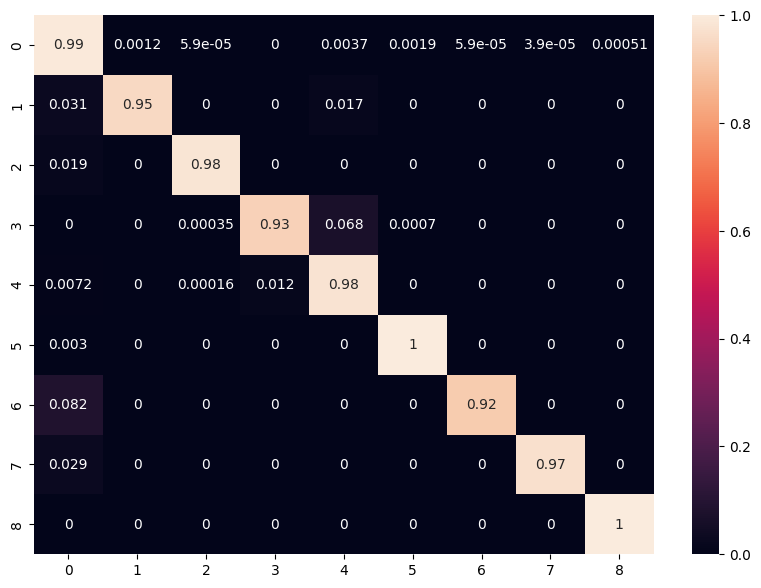

In [ ]:
cm = confusion_matrix(y_test_1, y_pred)
cm = pd.DataFrame(data=cm, columns = np.unique(y_test_1), index = np.unique(y_test_1))
cm = (cm / cm.sum(axis = 1).values.reshape(-1,1))  # to fractions of 1
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True)

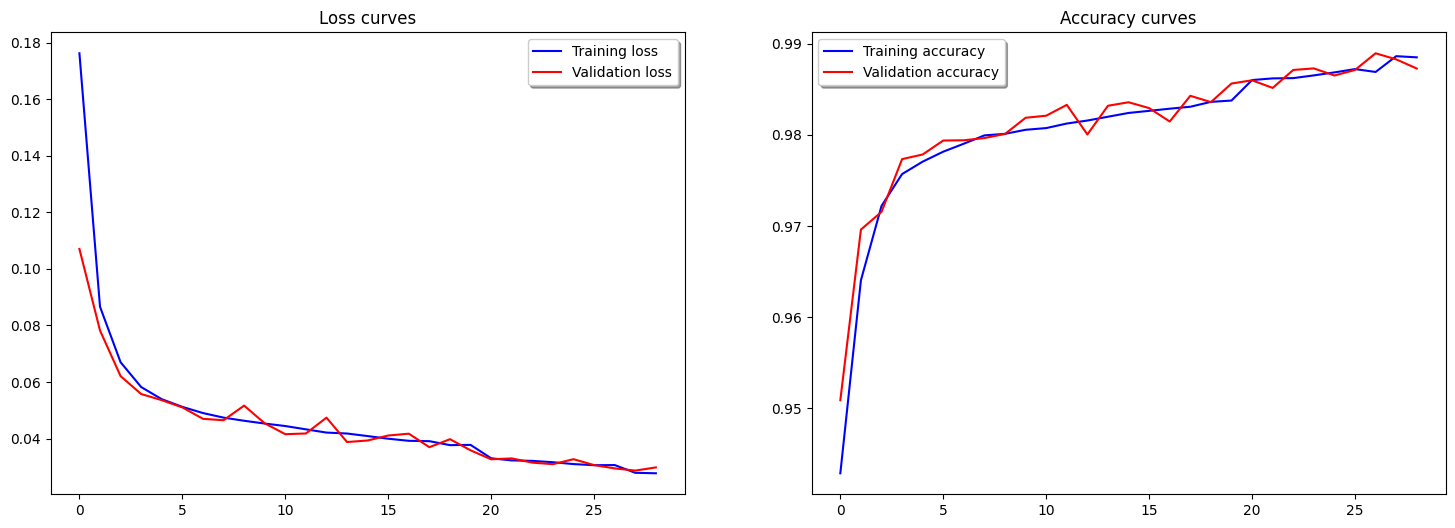

In [ ]:
# Plot the loss and accuracy curves over epochs:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
axs[0].plot(History.history['loss'], color='b', label='Training loss')
axs[0].plot(History.history['val_loss'], color='r', label='Validation loss')
axs[0].set_title("Loss curves")
axs[0].legend(loc='best', shadow=True)
axs[1].plot(History.history['accuracy'], color='b', label='Training accuracy')
axs[1].plot(History.history['val_accuracy'], color='r', label='Validation accuracy')
axs[1].set_title("Accuracy curves")
axs[1].legend(loc='best', shadow=True)
plt.show()

In [ ]:
# defining function for classification metrics
def clf_metrics(test, pred):
    '''Function returns basic metrics for classification models'''
    print('Classification Accuracy Score:', accuracy_score(test, pred))
    print('Confusion Matrix: \n', confusion_matrix(test, pred))
    print('Classification Report: \n', classification_report(test, pred, zero_division=0))
clf_metrics(y_test_1, y_pred)

Classification Accuracy Score: 0.9872814666723383
Confusion Matrix: 
 [[50454    60     3     0   187    96     3     2    26]
 [   13   400     0     0     7     0     0     0     0]
 [   10     0   520     0     0     0     0     0     0]
 [    0     0     1  2662   193     2     0     0     0]
 [   90     0     2   152 12199     0     0     0     0]
 [    5     0     0     0     0  1639     0     0     0]
 [    8     0     0     0     0     0    89     0     0]
 [   37     0     0     0     0     0     0  1256     0]
 [    0     0     0     0     0     0     0     0   411]]
Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.99      0.99     50831
           1       0.87      0.95      0.91       420
           2       0.99      0.98      0.98       530
           3       0.95      0.93      0.94      2858
           4       0.97      0.98      0.97     12443
           5       0.94      1.00      0.97      1644
           6

In [ ]:
data = [[i for i in item.values()] for item in logbook]
df = pd.DataFrame(data, columns=logbook.header)
print(df)

   gen  nevals       avg       std       min       max
0    0       5  0.062539  0.021205  0.045468  0.101611
1    1       2  0.044439  0.001947  0.040596  0.045822
2    2       2  0.041927  0.006229  0.032067  0.050910
3    3       2  0.031454  0.000980  0.029539  0.032067
4    4       3  0.030800  0.000823  0.029354  0.031531
5    5       2  0.029855  0.000653  0.029354  0.030962


In [ ]:
df2.to_csv('/content/gdrive/My Drive/Thesis/Logbook_GA.csv', index = True)

In [ ]:
#df2 = pd.read_csv('/content/gdrive/My Drive/Thesis/Logbook_GA.csv', index_col=0)

In [ ]:
#df2

,gen,nevals,avg,std,min,max
0,0,5,0.062539,0.021205,0.045468,0.101611
1,1,2,0.044439,0.001947,0.040596,0.045822
2,2,2,0.041927,0.006229,0.032067,0.050910
3,3,2,0.031454,0.000980,0.029539,0.032067
4,4,3,0.030800,0.000823,0.029354,0.031531
5,5,2,0.029855,0.000653,0.029354,0.030962


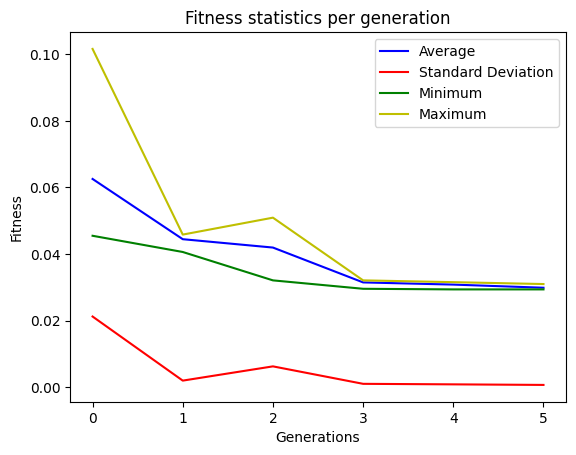

In [ ]:
plt.plot(df["gen"], df["avg"], 'b', label='Average')
plt.plot(df["gen"], df["std"], 'r', label='Standard Deviation')
plt.plot(df["gen"], df["min"], 'g', label='Minimum')
plt.plot(df["gen"], df["max"], 'y', label='Maximum')
plt.xlabel('Generations')
plt.ylabel('Fitness')
plt.title('Fitness statistics per generation')
plt.legend()
plt.show()